### Урок 4. Деревья решений

- В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.
- Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
from matplotlib.colors import ListedColormap
from sklearn import model_selection
from sklearn import datasets
import numpy as np

In [3]:
"""Код из методички."""
class Node:
    """Класс узла дерева."""
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


class Leaf:
    """Класс листа дерева"""
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred

    def predict(self):
        # подсчёт количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдём класс, количество объектов которого будет максимальным в этом листе, и вернём его
        prediction = max(classes, key=classes.get)
        return prediction

def gini(labels):
    """
    Расчёт критерия Джини
    :param labels:
    :return:
    """
    #  подсчёт количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчёт критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределённости
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
    return impurity

def quality(left_labels, right_labels, current_gini):
    """
    Расчёт качества
    :param left_labels:
    :param right_labels:
    :param current_gini:
    :return:
    """
    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

def split(data, labels, index, t):
    """
    Разбиение датасета в узле
    :param data:
    :param labels:
    :param index:
    :param t:
    :return:
    """
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels


def find_best_split(data, labels):
    """
    Нахождение наилучшего разбиения.
    :param data:
    :param labels:
    :return:
    """
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        t_values = [row[index] for row in data]

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, где в узле остаётся менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index


def build_tree(data, labels):
    """
    Построение дерева посредством рекурсивной функции.
    :param data:
    :param labels:
    :return:
    """
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай — прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


def classify_object(obj, node):
    """
    Проход объекта по дереву для его классификации.
    :param obj:
    :param node:
    :return:
    """
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)


def predict(data, tree):
    """
    Предсказание деревом для всего датасета.
    :param data:
    :param tree:
    :return:
    """
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes


def print_tree(node, spacing=""):
    """
    Вывод дерева.
    :param node:
    :param spacing:
    :return:
    """
    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

def accuracy_metric(actual, predicted):
    """
    Расчёт точности
    :param actual:
    :param predicted:
    :return:
    """
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


## Практическое задание

##### В коде из методички реализуйте один или несколько критериев останова: количество листьев, количество используемых признаков, глубина дерева и т. д.

In [4]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2,
                                                      n_classes = 2, n_redundant=0,
                                                      n_clusters_per_class=1, random_state=5, n_samples=800)

# разбиение данных
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                     classification_labels,
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

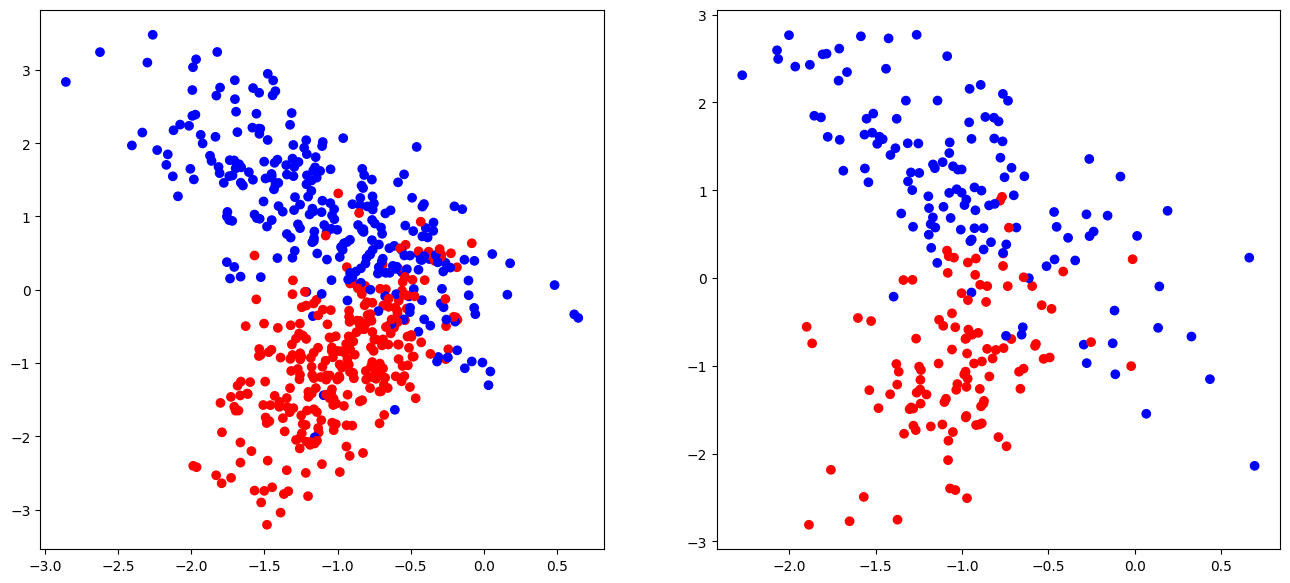

In [5]:
# Визулизация
plt.figure(figsize = (16, 7))

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.subplot(1,2,1)
plt.scatter(list(map(lambda x: x[0], train_data)), list(map(lambda x: x[1], train_data)),
              c=train_labels, cmap=colors)
plt.subplot(1,2,2)
plt.scatter(list(map(lambda x: x[0], test_data)), list(map(lambda x: x[1], test_data)),
              c=test_labels, cmap=colors)

Реализовано 2 критерия остановки
- Максимальная глубина
- Когда все объекты относятся к одному классу


In [6]:
def build_tree(data, labels, max_depth=None):
    """
    Построение дерева посредством рекурсивной функции.
    :param data: Массив данных
    :param labels: Массив классов
    :param max_depth: Критерий остановки по максимальной глубине дерева
    :return:
    """
    quality, t, index = find_best_split(data, labels)

    stop_criteria = quality == 0 #  Базовый случай — прекращаем рекурсию, когда нет прироста в качества
    if max_depth is not None: #  Если установлен критерий по макс. глубине
        stop_criteria |= max_depth == 0

    if stop_criteria:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels) if len(np.unique(true_labels))>1 else Leaf(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels) if len(np.unique(false_labels))>1 else Leaf(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)


In [7]:
my_tree = build_tree(train_data, train_labels, 5)
print_tree(my_tree)

Индекс 1
Порог 0.13487041249253684
--> True:
  Индекс 0
  Порог -0.4658201109093335
  --> True:
    Индекс 1
    Порог -0.40663390905814234
    --> True:
      Индекс 0
      Порог -0.6366685274725341
      --> True:
        Индекс 1
        Порог -1.4406012438209022
        --> True:
          Индекс 1
          Порог -1.4789199695363378
          --> True:
            Индекс 0
            Порог -1.1561705206128734
            --> True:
              Прогноз: 0
            --> False:
              Индекс 0
              Порог -1.128363547387334
              --> True:
                Прогноз: 0
              --> False:
                Прогноз: 0
          --> False:
            Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Индекс 0
        Порог -0.6023509932478426
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
    --> False:
      Индекс 0
      Порог -0.5249627609775233
      --> True:
        Индекс 1
        Порог -0.06

In [8]:
# Проверим
predicted_train = predict(train_data, my_tree)
predicted_test = predict(test_data, my_tree)

# Расчёт точности
train_accuracy = accuracy_metric(train_labels, predicted_train)
test_accuracy = accuracy_metric(test_labels, predicted_test)

print(f'Точность (train): {train_accuracy:.2f}\n'
      f'Точность (test): {test_accuracy:.2f}')

Точность (train): 93.39
Точность (test): 90.00


Text(0.5, 1.0, 'Test accuracy=90.00')

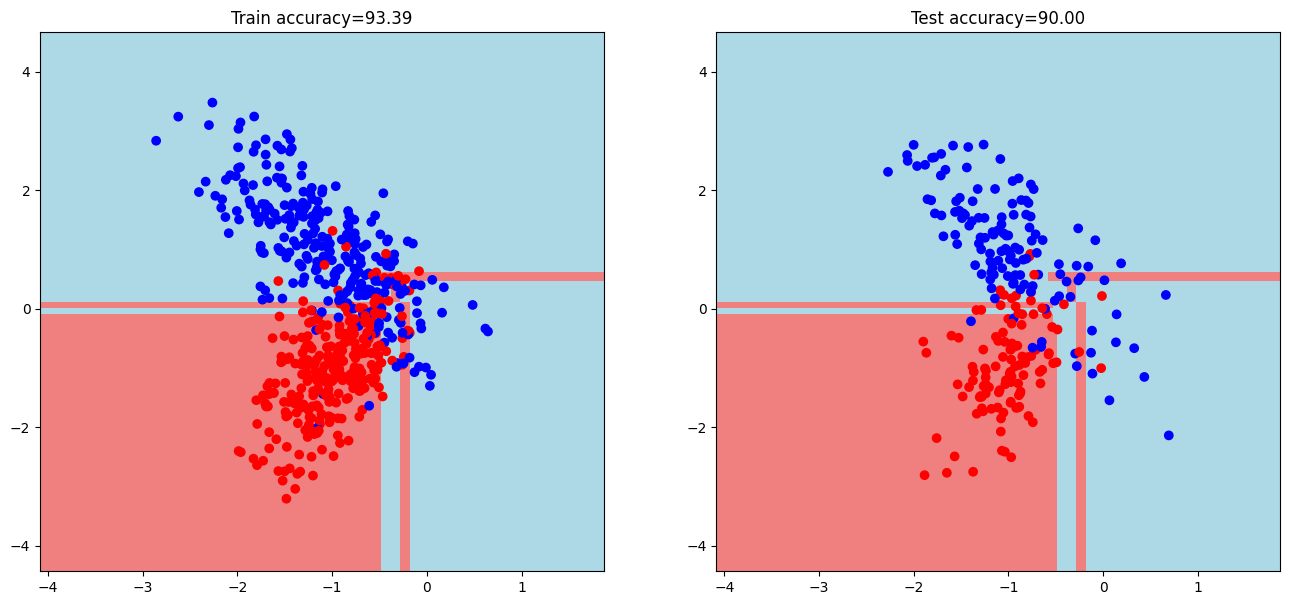

In [9]:
# Визуализация
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

##### Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [10]:
class RegLeaf(Leaf):
    """Класс листа для дерева решений регрессии"""
    def predict(self):
        return np.mean(self.labels, axis=0)

def dispersion(labels):
    return np.var(labels)

Так же необходимо обновить функцию разбиения и построения дерева

In [11]:
def disp_quality(left_labels, right_labels, current_dispersion):
    """
    Расчёт качества
    :param left_labels:
    :param right_labels:
    :param current_dispersion:
    :return:
    """
    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_dispersion - p * dispersion(left_labels) - (1 - p) * dispersion(right_labels)

def find_best_split(data, labels):
    """
    Нахождение наилучшего разбиения.
    :param data:
    :param labels:
    :return:
    """
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_criteria = dispersion(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        t_values = [row[index] for row in data]

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, где в узле остаётся менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_criteria)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [13]:
def build_tree(data, labels, max_depth=None):
    quality, t, index = find_best_split(data, labels)

    stop_criteria = quality == 0 #  Базовый случай — прекращаем рекурсию, когда нет прироста в качества
    if max_depth is not None: #  Если установлен критерий по макс. глубине
        stop_criteria |= max_depth == 0

    if stop_criteria:
        return RegLeaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels) if len(np.unique(true_labels))>1 else RegLeaf(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels) if len(np.unique(false_labels))>1 else RegLeaf(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)